In [1]:
import pandas as pd
from datetime import datetime
from tqdm import tqdm, tqdm_notebook

In [4]:
csv_filename = '../data/logs/'
groupby_time_frequency = 'H' # H indicates hourly
aggregate_csv_filename = '../agg_temp.csv'

In [5]:
import xmltodict
from tqdm import tqdm
import pandas as pd
import argparse


def get_aggregate_df(mxml_filename, groupby_time_frequency):
    print('Converting MXML to CSV', )
    df = pd.DataFrame(columns=['case_id', 'activity', 'resource', 'complete_timestamp'])

    with open(mxml_filename) as f:
        doc = xmltodict.parse(f.read())

    for instance in tqdm(doc['WorkflowLog']['Process']['ProcessInstance']):
        case_id = instance['@id']
        resource = None
        iterator = instance['AuditTrailEntry']
        iterator.sort(key=lambda x: x['Timestamp'])
        for entry in iterator:
            if entry['EventType'] == 'assign':
                try:
                    resource = entry['Originator']
                except KeyError:
                    resource = None
                continue
            df = df.append({
                'case_id': case_id,
                'activity': entry['WorkflowModelElement'],
                'resource': resource,
                'complete_timestamp': entry['Timestamp']
            }, ignore_index=True)

    return df

In [6]:
df = get_aggregate_df('../data/logs/A.1.0/1.mxml', 'H')
df['completion_datetime'] = pd.to_datetime(df.complete_timestamp, format='%Y-%m-%dT%H:%M:%S.%f+00:00')
df.drop(columns='complete_timestamp', inplace=True)
df.fillna('None', inplace=True)
df.head()

Converting MXML to CSV


100%|██████████| 5000/5000 [02:12<00:00, 37.78it/s]


,case_id,activity,resource,completion_datetime
0,2182,Start Event,None,2019-05-24 11:04:37.943
1,2182,Task 1,Resource 1,2019-05-24 11:10:55.750
2,2182,Task 2,Resource 2,2019-05-27 09:05:39.287
3,2182,Task 3,Resource 1,2019-05-27 09:09:58.065
4,2182,End Event,None,2019-05-27 09:09:58.065


In [6]:
list(df['resource'].unique()) + list(df['activity'].unique()) + ['count']

['None',
 'Resource 1',
 'Resource 2',
 'Start Event',
 'Task 1',
 'Task 2',
 'Task 3',
 'End Event',
 'count']

In [8]:
all_columns = ['timestamp'] + list(df['resource'].unique()) + list(df['activity'].unique())
data_aggregate = pd.DataFrame(columns=all_columns)

grouped = df.groupby(pd.Grouper(key='completion_datetime', freq=groupby_time_frequency))
for name1, group1 in tqdm(grouped):
    temp_row = {key: 0 for key in all_columns}
    temp_row['timestamp'] = name1
    for name2, group2 in group1.groupby(['activity', 'resource']):
        count = len(group2['case_id'].unique())
        temp_row[name2[0]] += count
        temp_row[name2[1]] += count
    data_aggregate = data_aggregate.append(temp_row, ignore_index=True)

100%|██████████| 7064/7064 [00:31<00:00, 222.73it/s]


In [10]:
data_aggregate.head()

,timestamp,None,Resource 1,Resource 2,Start Event,Task 1,Task 2,Task 3,End Event
0,2019-01-16 09:00:00,7,5,2,4,4,2,2,2
1,2019-01-16 10:00:00,6,7,2,3,3,3,3,3
2,2019-01-16 11:00:00,8,7,4,4,3,4,4,4
3,2019-01-16 12:00:00,6,6,3,3,3,3,3,3
4,2019-01-16 13:00:00,6,7,3,4,5,3,2,2


In [18]:
to_csv_df = data_aggregate.drop(columns=['timestamp', 'None'])
to_csv_df.to_csv('new_aggregate.csv', index=False)

In [19]:
to_csv_df.head(15)

,Resource 1,Resource 2,Start Event,Task 1,Task 2,Task 3,End Event
0,5,2,4,4,2,2,2
1,7,2,3,3,3,3,3
2,7,4,4,3,4,4,4
3,6,3,3,3,3,3,3
4,7,3,4,5,3,2,2
5,6,2,3,3,2,3,3
6,6,3,3,3,3,3,3
7,3,2,1,1,2,2,2
8,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0


In [17]:
len(to_csv_df), len(data_aggregate['timestamp'])

(7064, 7064)

-----

In [9]:
# data_aggregate.to_csv('../new_aggregate.csv', index=False)

In [21]:
from pgmpy.models import BayesianModel

In [35]:
from pgmpy.estimators import BdeuScore, K2Score, BicScore
from pgmpy.estimators import HillClimbSearch

data = data_aggregate.drop(columns=['timestamp', 'count'])
hc = HillClimbSearch(data, scoring_method=BicScore(data))
best_model = hc.estimate()

In [39]:
hc = HillClimbSearch(data, scoring_method=BicScore(data))
base_model = BayesianModel([('Start Event', 'Task 1'),
                     ('Task 1', 'Task 2'),
                     ('Task 2', 'Task 3'),
                     ('Task 3', 'End Event'),
                     ('Resource 1', 'Task 1'),
                     ('Resource 2', 'Task 2'),
                     ('Resource 1', 'Task 3'),
                     ('None', 'Start Event')])
best_model = hc.estimate(start=base_model, max_indegree=3)

print(best_model.edges())

[('Start Event', 'End Event'), ('Task 1', 'Task 3'), ('Task 1', 'End Event'), ('Task 1', 'Start Event'), ('Task 2', 'Task 3'), ('Task 2', 'Task 1'), ('Resource 1', 'Task 1'), ('Resource 1', 'Task 3'), ('Resource 2', 'Task 2'), ('Resource 2', 'Resource 1'), ('None', 'Start Event'), ('None', 'Resource 1'), ('None', 'End Event'), ('None', 'Resource 2'), ('None', 'Task 2')]


/Users/tanmayee/anaconda/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/tanmayee/anaconda/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/tanmayee/anaconda/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Users/tanmayee/anaconda/envs/py36/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_stri

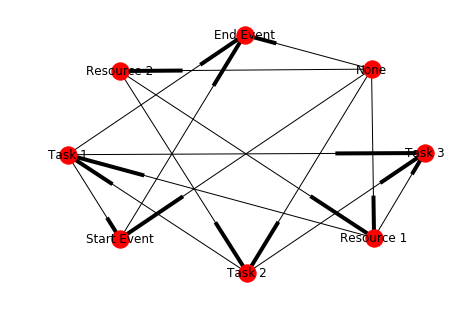

In [40]:
import networkx as nx
import pylab as plt
nx.draw(best_model, with_labels=True)
plt.show()

-----

In [41]:
aggregate_df = pd.DataFrame(columns=['timestamp', 'activity', 'resource', 'count'])

grouped = df.groupby(pd.Grouper(key='completion_datetime', freq=groupby_time_frequency))
for name1, group1 in tqdm(grouped):
    for name2, group2 in group1.groupby(['activity', 'resource']):
        aggregate_df = aggregate_df.append({
                'timestamp': name1,
                'activity': name2[0],
                'resource': name2[1],
                'count': len(group2['case_id'].unique())
            }, ignore_index=True)

aggregate_df.head()

100%|██████████| 7064/7064 [00:48<00:00, 145.60it/s]


,timestamp,activity,resource,count
0,2019-01-16 09:00:00,End Event,None,2
1,2019-01-16 09:00:00,Start Event,None,4
2,2019-01-16 09:00:00,Task 1,None,1
3,2019-01-16 09:00:00,Task 1,Resource 1,3
4,2019-01-16 09:00:00,Task 2,Resource 2,2


In [67]:
aggregate_df.to_csv(aggregate_csv_filename, index=False)